# Multi-Harmonic Controlled Noise Drowning with Subharmonic Driving (MHCND-SD) - Qiskit Implementation

## Overview
This notebook implements the MHCND-SD method for qubit stability enhancement using controlled noise and multi-harmonic subharmonic driving.


## Code Sections

### Import Libraries

In [1]:
from qiskit_dynamics.models import HamiltonianModel, LindbladModel
from qiskit_dynamics.signals import Signal
from qiskit_dynamics.solvers import solve_lmde
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.interpolate import interp1d

### Define Qubit Parameters

Initialize qubit and noise frequencies, harmonic amplitudes, and simulation time.

In [2]:
# Number of qubits
num_qubits = 2

# Qubit frequencies (in rad/ns)
omega_q1 = 2 * np.pi * 5.0  # Qubit 1 frequency (5 GHz)
omega_q2 = 2 * np.pi * 5.0  # Qubit 2 frequency (5 GHz)

# Subharmonic driving frequencies (multiple harmonics)
omega_d1 = omega_q1 / 2     # First harmonic (1/2) for both qubits
omega_d2 = omega_q1 / 3     # Second harmonic (1/3)
omega_d3 = omega_q1 / 4     # Third harmonic (1/4)

# Amplitudes for each harmonic
A_d1 = 0.05 * omega_q1      # Amplitude for first harmonic
A_d2 = 0.05 * omega_q1      # Amplitude for second harmonic
A_d3 = 0.05 * omega_q1      # Amplitude for third harmonic

# Controlled noise parameters
A_controlled_noise = 0.02 * omega_q1  # Controlled noise amplitude
omega_noise = 2 * np.pi * 10.0        # Controlled noise frequency (10 GHz)

# Time span for simulation in nanoseconds
t_span = [0, 500]

# Time steps for stochastic noise (smaller step for higher resolution)
time_steps = np.linspace(t_span[0], t_span[1], 1000)

### Define Pauli Matrices and Tensor Products
Define identity and Pauli matrices to represent qubit states.

In [3]:
# Pauli matrices for single qubit
I = np.array([[1, 0], [0, 1]])          # Identity matrix
pauli_x = np.array([[0, 1], [1, 0]])    # Pauli-X matrix
pauli_y = np.array([[0, -1j], [1j, 0]]) # Pauli-Y matrix
pauli_z = np.array([[1, 0], [0, -1]])   # Pauli-Z matrix
sigma_minus = np.array([[0, 0], [1, 0]])  # Lowering operator

# Tensor products for two qubits
def tensor(op1, op2):
    return np.kron(op1, op2)

# Operators for two qubits
I2 = tensor(I, I)
X1 = tensor(pauli_x, I)
X2 = tensor(I, pauli_x)
Z1 = tensor(pauli_z, I)
Z2 = tensor(I, pauli_z)
sigma_minus1 = tensor(sigma_minus, I)
sigma_minus2 = tensor(I, sigma_minus)

### Define Lindblad Operators for Damping

Set up Lindblad operators to model amplitude and phase damping.

In [4]:
# Relaxation rates for amplitude and phase damping
gamma_amplitude = 0.01  # Amplitude damping rate
gamma_phase = 0.01      # Phase damping rate

# Lindblad dissipators for each qubit
lindblad_ops = [
    np.sqrt(gamma_amplitude) * sigma_minus1,  # Amplitude damping for qubit 1
    np.sqrt(gamma_phase) * Z1,                # Phase damping for qubit 1
    np.sqrt(gamma_amplitude) * sigma_minus2,  # Amplitude damping for qubit 2
    np.sqrt(gamma_phase) * Z2                 # Phase damping for qubit 2
]

# Create constant signals for each dissipator
dissipator_signals = [Signal(envelope=1.0) for _ in lindblad_ops]

### Generate Stochastic Noise

Define a function to create stochastic noise for each qubit.

In [5]:
# Function to generate stochastic noise signal
def stochastic_noise(amplitude, time_steps):
    np.random.seed(42)  # For reproducibility
    return amplitude * np.random.normal(0, 1, size=len(time_steps))

# Generate stochastic noise for each qubit
stochastic_noise_q1 = stochastic_noise(0.01 * omega_q1, time_steps)
stochastic_noise_q2 = stochastic_noise(0.01 * omega_q2, time_steps)

### Set up Hamiltonian and Lindblad Models

Initialize the Hamiltonian and Lindblad models with time-dependent signals for controlled noise and subharmonic driving.

In [6]:
# Define time-dependent signals for subharmonic driving and controlled noise
subharmonic_drive_signal1 = Signal(envelope=A_d1, carrier_freq=omega_d1)
subharmonic_drive_signal2 = Signal(envelope=A_d2, carrier_freq=omega_d2)
subharmonic_drive_signal3 = Signal(envelope=A_d3, carrier_freq=omega_d3)
controlled_noise_signal = Signal(envelope=A_controlled_noise, carrier_freq=omega_noise)

# List of all signals
signals = [
    subharmonic_drive_signal1,
    subharmonic_drive_signal2,
    subharmonic_drive_signal3,
    controlled_noise_signal,
    subharmonic_drive_signal1,
    subharmonic_drive_signal2,
    subharmonic_drive_signal3,
    controlled_noise_signal
]

In [7]:
# Hamiltonian components
static_hamiltonian = 0.5 * omega_q1 * Z1 + 0.5 * omega_q2 * Z2  # Qubit frequencies

# Interaction term (crosstalk between qubits)
J = 0.02 * omega_q1  # Interaction strength
interaction_hamiltonian = J * tensor(pauli_x, pauli_x)  # Qubit-qubit interaction

# Time-dependent operators
operators = [
    0.5 * X1,  # Subharmonic drive on qubit 1
    0.5 * X1,
    0.5 * X1,
    0.5 * X1,  # Controlled noise on qubit 1
    0.5 * X2,  # Subharmonic drive on qubit 2
    0.5 * X2,
    0.5 * X2,
    0.5 * X2   # Controlled noise on qubit 2
]

# Corresponding signals (same signals for both qubits)
signals = [
    subharmonic_drive_signal1,
    subharmonic_drive_signal2,
    subharmonic_drive_signal3,
    controlled_noise_signal,
    subharmonic_drive_signal1,
    subharmonic_drive_signal2,
    subharmonic_drive_signal3,
    controlled_noise_signal
]

In [8]:
# Interpolate stochastic noise over the time span
noise_interp_q1 = interp1d(time_steps, stochastic_noise_q1, kind='linear', fill_value="extrapolate")
noise_interp_q2 = interp1d(time_steps, stochastic_noise_q2, kind='linear', fill_value="extrapolate")

# Define functions to return noise at any time t
def noise_signal_q1(t):
    return noise_interp_q1(t)

def noise_signal_q2(t):
    return noise_interp_q2(t)

# Create custom signals for stochastic noise
stochastic_noise_signal_q1 = Signal(envelope=noise_signal_q1)
stochastic_noise_signal_q2 = Signal(envelope=noise_signal_q2)

# Add stochastic noise operators and signals
operators += [0.5 * Z1, 0.5 * Z2]  # Using Z operators for dephasing noise
signals += [stochastic_noise_signal_q1, stochastic_noise_signal_q2]


In [9]:
# Define the Lindblad model
model_with_noise = LindbladModel(
    static_hamiltonian=static_hamiltonian,
    hamiltonian_operators=operators,
    hamiltonian_signals=signals,
    dissipator_operators=lindblad_ops,
    dissipator_signals=dissipator_signals
)

In [10]:
# Initial state: both qubits in |0⟩ state
initial_state = np.zeros((4, 4), dtype=complex)
initial_state[0, 0] = 1.0  # State |00⟩⟨00|

y0 = initial_state  # Use the density matrix directly

### Run Simulation and Extract Probabilities

Solve the master equation and plot the probabilities of each state over time.

In [11]:
# Solve the master equation
results = solve_lmde(
    generator=model_with_noise,
    t_span=t_span,
    y0=y0,
    t_eval=time_steps,
    method='DOP853',
    atol=1e-10,
    rtol=1e-10
)

In [15]:
# The solver returns density matrices directly; no need to reshape
density_matrices = results.y  # This is already an array of matrices

# Extract probabilities of the computational basis states
# Basis states: |00⟩, |01⟩, |10⟩, |11⟩
p_00 = np.real(density_matrices[:, 0, 0])  # Probability of |00⟩
p_01 = np.real(density_matrices[:, 1, 1])  # Probability of |01⟩
p_10 = np.real(density_matrices[:, 2, 2])  # Probability of |10⟩
p_11 = np.real(density_matrices[:, 3, 3])  # Probability of |11⟩

### Plot Probabilities

Plot the probabilities of states |00⟩, |01⟩, |10⟩, and |11⟩.

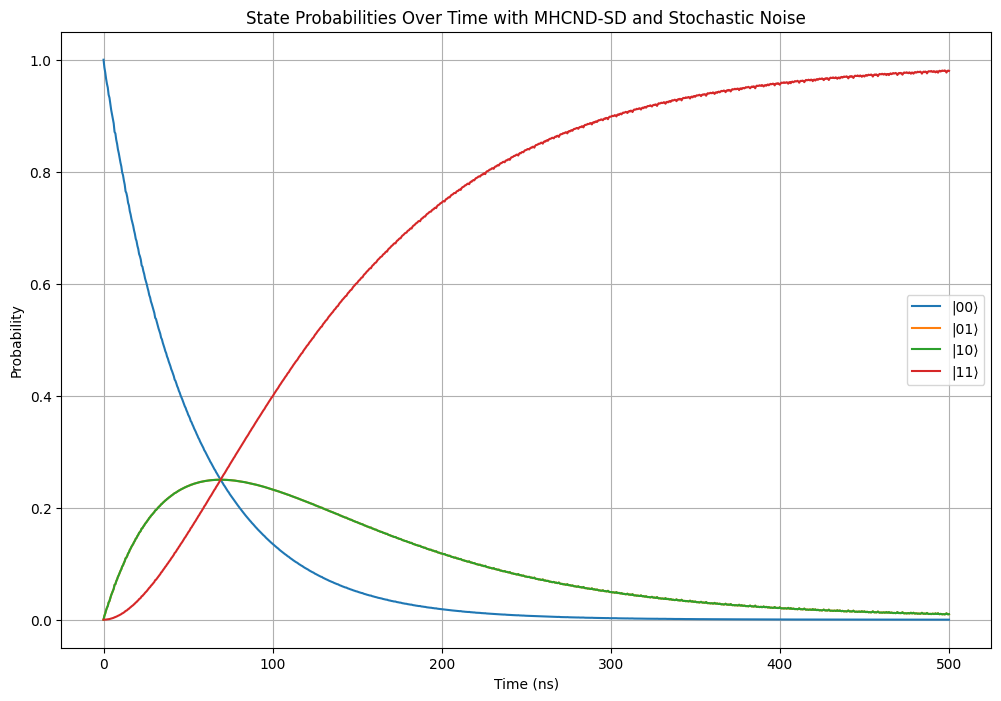

In [13]:
# Plot probabilities over time
plt.figure(figsize=(12, 8))
plt.plot(results.t, p_00, label="|00⟩")
plt.plot(results.t, p_01, label="|01⟩")
plt.plot(results.t, p_10, label="|10⟩")
plt.plot(results.t, p_11, label="|11⟩")
plt.xlabel('Time (ns)')
plt.ylabel('Probability')
plt.title('State Probabilities Over Time with MHCND-SD and Stochastic Noise')
plt.legend()
plt.grid(True)
plt.show()

### Sensitivity Analysis

Conduct a sensitivity analysis by varying damping rates and observing effects on qubit states.

In [ ]:
"""Work in Progress. Requires too much compute to run locally."""
# Sensitivity Analysis: Varying damping rates
gamma_amplitude_values = [0.005, 0.01, 0.02]  # Different amplitude damping rates
gamma_phase_values = [0.005, 0.01, 0.02]      # Different phase damping rates

plt.figure(figsize=(12, 8))

for gamma_a in gamma_amplitude_values:
    for gamma_p in gamma_phase_values:
        # Update Lindblad operators with new damping rates
        lindblad_ops = [
            np.sqrt(gamma_a) * sigma_minus1,
            np.sqrt(gamma_p) * Z1,
            np.sqrt(gamma_a) * sigma_minus2,
            np.sqrt(gamma_p) * Z2
        ]

        # Create new dissipator signals
        dissipator_signals = [Signal(envelope=1.0) for _ in lindblad_ops]

        # Update the Lindblad model
        model_with_noise = LindbladModel(
            static_hamiltonian=static_hamiltonian,
            hamiltonian_operators=operators,
            hamiltonian_signals=signals,
            dissipator_operators=lindblad_ops,
            dissipator_signals=dissipator_signals
        )

        # Solve the master equation
        results = solve_lmde(
            generator=model_with_noise,
            t_span=t_span,
            y0=y0,  # y0 is the initial density matrix
            t_eval=time_steps,
            method='DOP853',
            atol=1e-10,
            rtol=1e-10
        )

        # Use results.y directly without reshaping
        density_matrices = results.y  # Already an array of density matrices
        p_00 = np.real(np.diagonal(density_matrices, axis1=1, axis2=2)[:, 0])

        # Plot the probability of |00⟩ state
        label = f"γₐ={gamma_a}, γₚ={gamma_p}"
        plt.plot(results.t, p_00, label=label)

plt.xlabel('Time (ns)')
plt.ylabel('Probability of |00⟩')
plt.title('Sensitivity Analysis: Effect of Damping Rates on |00⟩ State')
plt.legend()
plt.grid(True)
plt.show()

### Check Final Probabilities

Print final probabilities and check if coherence is maintained.

In [ ]:
# Print final probabilities for one of the simulations
print(f"Final probabilities with γ_amplitude={gamma_amplitude}, γ_phase={gamma_phase}:")
print(f"P(|00⟩) = {p_00[-1]:.4f}")
print(f"P(|01⟩) = {p_01[-1]:.4f}")
print(f"P(|10⟩) = {p_10[-1]:.4f}")
print(f"P(|11⟩) = {p_11[-1]:.4f}")

# Check if coherence is maintained
if p_00[-1] > 0.9:
    print("High coherence maintained in |00⟩ state.")
else:
    print("Decoherence observed; coherence not maintained in |00⟩ state.")